Customize: Modeling Positions
=============================

Before fitting a strong lens, we can manually specify a grid of image-plane coordinates corresponding to the multiple
images of the lensed source-galaxy(s). During the model-fit, **PyAutoLens** will check that these coordinates trace
within a specified arc-second threshold of one another in the source-plane. If they do not meet this threshold, the
mass model is discarded and a new sample is generated by the non-linear search.

**Benefits:** The model-fit is faster, as the non-linear search avoids regions of parameter space where the mass-model
is clearly not accurate. Removing these unphysical solutions may also mean that the global-maximum solution is inferred
instead of a local-maxima, given that removing unphysical mass models makes non-linear parameter space less complex.

**Downsides:** If the positions are inaccurate or threshold is set too low, one may inadvertantly remove the correct
mass model!

The positions are associated with the `Imaging` dataset and they are loaded from a `positions.json` file which is in the
same folder as the dataset itself. To create this file, we used a GUI to `draw on` the positions with our mouse. This
GUI can be found in the script:

 `autolens_workspace/notebooks/preprocess/imaging/gui/positions.py`

If you wish to use positions for modeling your own lens data, you should use this script to draw on the positions of
every lens in you dataset.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Dataset + Masking__

Load and plot the strong lens dataset `mass_sie__source_sersic` via .fits files, which we will fit with the lens model.

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging = imaging.apply_mask(mask=mask)

__Positions__

The positions are loaded from a `positions.json` file which is in the same folder as the dataset itself. 

To create this file, we used a GUI to `draw on` the positions with our mouse. This GUI can be found in the 
script `autolens_workspace/notebooks/imaging/preprocess/gui/positions.py`

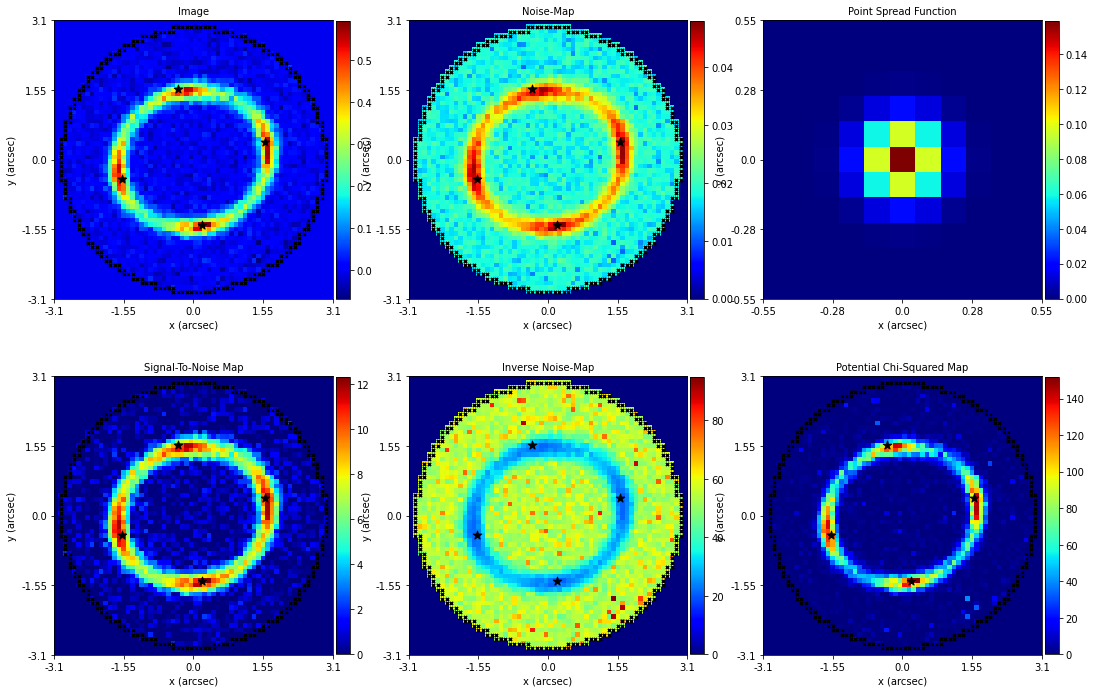

In [3]:
positions = al.Grid2DIrregular.from_json(
    file_path=path.join(dataset_path, "positions.json")
)

visuals_2d = aplt.Visuals2D(mask=mask, positions=positions)
imaging_plotter = aplt.ImagingPlotter(imaging=imaging, visuals_2d=visuals_2d)
imaging_plotter.subplot_imaging()

Alternatively, the positions can be specified manually in the runner script using the `Grid2DIrregular`object.
 
Below, we specify a list of (y,x) coordinates (that are not on a uniform or regular grid) which correspond to the 
arc-second (y,x) coordinates ot he lensed source's brightest pixels.

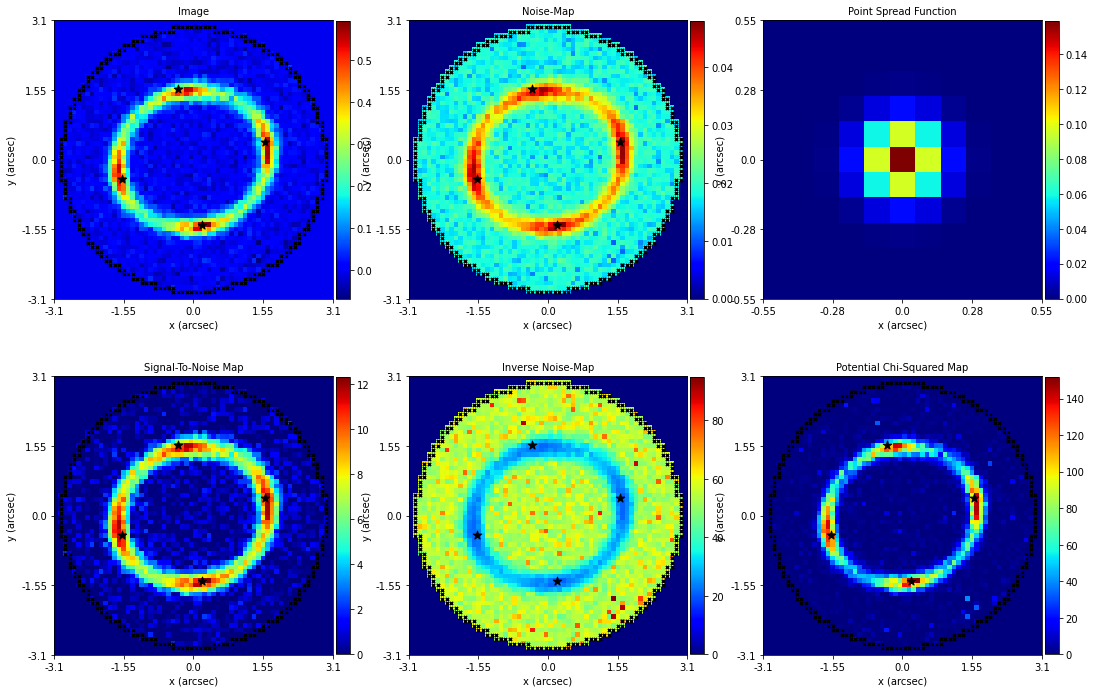

In [4]:
positions = al.Grid2DIrregular(
    [(0.4, 1.6), (1.58, -0.35), (-0.43, -1.59), (-1.45, 0.2)]
)

visuals_2d = aplt.Visuals2D(mask=mask, positions=positions)
imaging_plotter = aplt.ImagingPlotter(imaging=imaging, visuals_2d=visuals_2d)
imaging_plotter.subplot_imaging()

__Model + Search__ 

The code below performs the normal steps to set up a model-fit. We omit comments of this code as you should be 
familiar with it and it is not specific to this example!

In [5]:
lens = af.Model(al.Galaxy, redshift=0.5, mass=al.mp.EllIsothermal)
source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllSersic)

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

search = af.DynestyStatic(
    path_prefix=path.join("imaging", "customize"), name="positions"
)

__Analysis__

When creating the `AnalysisImaging` object, we pass the `positions` loaded above alongside a `SettingsLens` object with 
a `positions_threshold=0.5`. This requires that a mass model traces the four (y,x) coordinates specified by our 
positions (that correspond to the brightest regions of the lensed source) within 0.5" of one another in the source-plane, 
else the mass model is discarded and a new model is sampled. 

The threshold of 0.5" is large. For an accurate lens model we would anticipate the positions trace within < 0.01" of
one another. However, we only want the threshold to aid the non-linear with the choice of mass model, but not risk 
removing genuinely physical models.

In [6]:
analysis = al.AnalysisImaging(
    dataset=imaging,
    positions=positions,
    settings_lens=al.SettingsLens(positions_threshold=0.5),
)

__Model-Fit__

We can now begin the model-fit by passing the model and analysis object to the search, which performs a non-linear
search to find which models fit the data with the highest likelihood.

Because the `AnalysisImaging` was passed positions, many unphysical mass models will be discarded, speeding up the
model-fit.

In [7]:
result = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 10.71it/s, +50 | bound: 0 | nc: 1 | ncall: 52 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.059]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


__Wrap Up__

In this example, we used positional information about the lensed source galaxy's multiple images to speed up our
model-fit and make it more robust. Advanced **PyAutoLens** use will introduce a technique called non-linear search
chaining, which performs a model-fit as a sequence of many non-linear searches. This includes a feature called 
'automatic positions' which automatically computes the positions and updates the positions threshold, based on a 
previous mass model. This is detailed in the script:

 `autolens_workspace/imaging/notebooks/chaining/examples/parametric_to_inversion.py`.